In [1]:
!pip install torchinfo

You should consider upgrading via the 'C:\projects\python\NN\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam

from torchvision.datasets import Caltech101

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from torchvision import transforms

from pytorchtools import EarlyStopping  # from https://github.com/Bjarten/early-stopping-pytorch

from torchinfo import summary

In [2]:
IS_COLAB = False

if IS_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_DIR = "/content/drive/My Drive/ai/lab2/"

else:
    DATA_DIR = "./data/"

# Load dataset

In [3]:
from torchvision.datasets.utils import download_and_extract_archive, extract_archive


class Caltech101Fixed(Caltech101):

    def __init__(self, root: str, target_type="category", transform=None,
                 target_transform=None, download: bool = False) -> None:
        super().__init__(root, target_type, transform, target_transform, download)

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        download_and_extract_archive(
            "https://data.caltech.edu/tindfiles/serve/e41f5188-0b32-41fa-801b-d1e840915e80",
            self.root,
            md5="3138E1922A9193BFA496528EDBBC45D0".lower(),
            filename="caltech-101.zip"
        )

        extract_archive(self.root + "/caltech-101/101_ObjectCategories.tar.gz", self.root, True)

        extract_archive(self.root + "/caltech-101/Annotations.tar", self.root, True)

In [4]:
IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize([(IMG_SIZE, IMG_SIZE)]),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

data = Caltech101Fixed(DATA_DIR, download=True, transform=transform,
                       target_transform=lambda y: torch.zeros(101, dtype=torch.float).scatter_(0, torch.tensor(y),
                                                                                               value=1))

Files already downloaded and verified


In [5]:
data

Dataset Caltech101Fixed
    Number of datapoints: 8677
    Root location: ./data/caltech101
    Target type: ['category']
    StandardTransform
Transform: Compose(
               Resize(size=[(224, 224)], interpolation=bilinear, max_size=None, antialias=None)
               Lambda()
               ToTensor()
           )
Target transform: <function <lambda> at 0x000001F59C3389D0>

In [6]:
BATCH_SIZE = 16

train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = random_split(data, [train_size, test_size])

print("Train:", len(train))
print("Test:", len(test))

train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

Train: 6941
Test: 1736


Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


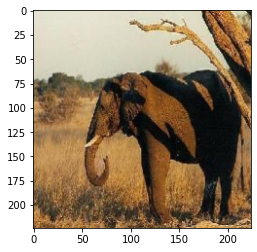

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


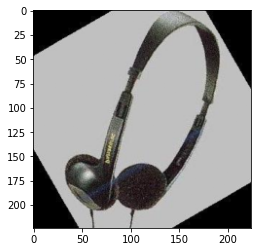

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


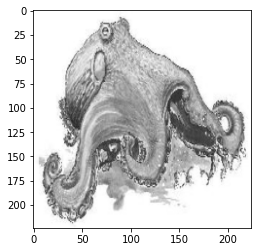

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


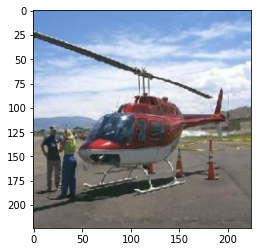

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


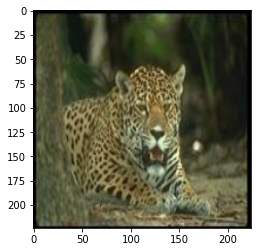

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


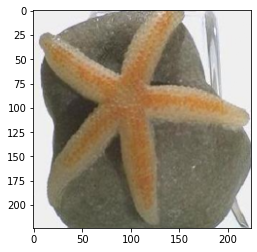

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


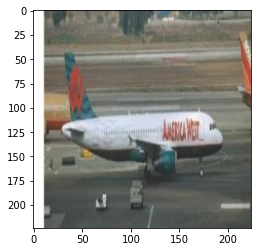

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


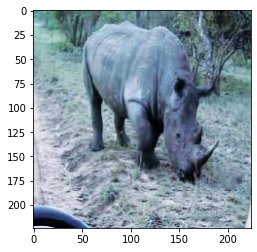

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


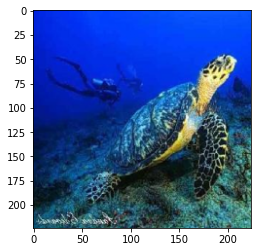

Image size: torch.Size([3, 224, 224]) class: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


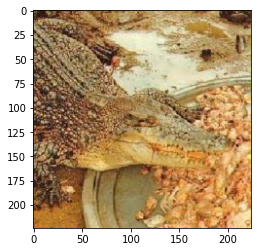

In [92]:
for i, (X, y) in enumerate(test_dataloader):
    if i >= 10:
        break

    print("Image size:", X[1].size(), "class:", y[1])

    plt.imshow(X[1].permute(1, 2, 0))
    plt.show()

In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16, 101])


# Plain 3-layer CNN

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        flatten_size = int((((IMG_SIZE - 3 * 4) / 2) ** 2) * 128)

        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(3, 20, 5),
            nn.ReLU(),
            nn.Conv2d(20, 64, 5),
            nn.ReLU(),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            nn.Flatten(),
            nn.Linear(flatten_size, 286),
            nn.ReLU(),
            nn.Linear(286, 101)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = CNN()

In [9]:
summary(model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [16, 101]                 --
│    └─Conv2d: 2-1                       [16, 20, 220, 220]        1,520
│    └─ReLU: 2-2                         [16, 20, 220, 220]        --
│    └─Conv2d: 2-3                       [16, 64, 216, 216]        32,064
│    └─ReLU: 2-4                         [16, 64, 216, 216]        --
│    └─Conv2d: 2-5                       [16, 128, 212, 212]       204,928
│    └─ReLU: 2-6                         [16, 128, 212, 212]       --
│    └─MaxPool2d: 2-7                    [16, 128, 106, 106]       --
│    └─Dropout2d: 2-8                    [16, 128, 106, 106]       --
│    └─Flatten: 2-9                      [16, 1438208]             --
│    └─Linear: 2-10                      [16, 286]                 411,327,774
│    └─ReLU: 2-11                        [16, 286]              

In [14]:
import torchvision

summary(torchvision.models.resnet18(), input_size=(32, 3, IMG_SIZE, IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   --                        --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to("cuda"), y.to("cuda")
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [17]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to("cuda"), y.to("cuda")

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=patience, verbose=True)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)

    early_stopping(test_loss, model)

    if early_stopping.early_stop:
        print(f"Early stopping, epoch {t + 1}")
        break

print("Done!")

Epoch 1
-------------------------------


RuntimeError: CUDA out of memory. Tried to allocate 352.00 MiB (GPU 0; 4.00 GiB total capacity; 2.12 GiB already allocated; 66.98 MiB free; 2.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Frozen pre-trained ResNet as feature extractor

# Fine-tuned pre-trained ResNet